In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import librosa
import os
import pandas as pd
import scipy.signal as signal
import seaborn as sns

In [ ]:
import whisper
from jiwer import wer
model = whisper.load_model("turbo", device="cuda")

In [ ]:
dataset_folder = '../dataset/Bone/1hlx_extend'
audio_folder = os.path.join(dataset_folder, 'audio')
audio_files = os.listdir(audio_folder)

sentences_path = os.path.join(dataset_folder, "sentences.csv")
sentences = pd.read_csv(sentences_path, header=[0])
wer_scores = []
for index, row in sentences.iterrows():
    audio_file, sentence = row['filename'], row['sentence']
    audio_file = os.path.join(audio_folder, audio_file)
    result = model.transcribe(audio_file)
    predicted_text = result['text'].replace('.', '')
    try:
        wer_score = wer(predicted_text, sentence)
        wer_scores.append(wer_score)
    except:
        print('Error:', audio_file)
print('Average WER:', np.mean(wer_scores))

Error: ../dataset/Bone/1hlx_extend/audio/210.wav
Error: ../dataset/Bone/1hlx_extend/audio/301.wav
Average WER: 1.2040533484810594


Text(0.5, 0, 'WER')

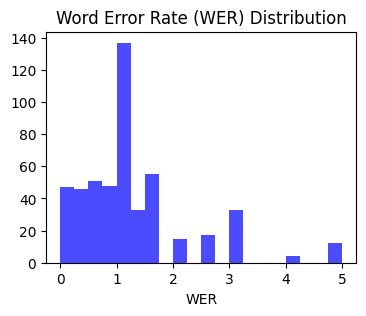

In [40]:
# Plotting the WER scores in a histogram
plt.figure(figsize=(4, 3))
plt.hist(wer_scores, bins=20, color='blue', alpha=0.7)
plt.title('Word Error Rate (WER) Distribution')
plt.xlabel('WER')

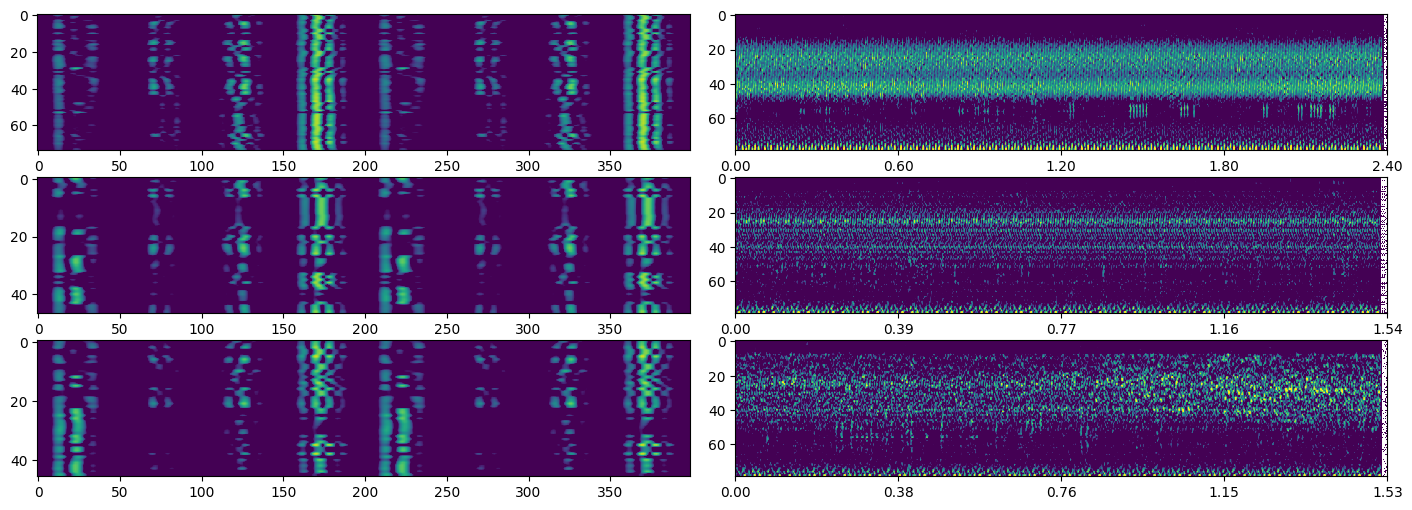

In [11]:
from preprocess.feature import extract_reflected_features
dataset_folder = '../dataset/BCH/EchoBone/1hlx_extend'
features_folder = os.path.join(dataset_folder, 'features')
audio_folder = os.path.join(dataset_folder, 'audio')

sentences_path = os.path.join(dataset_folder, "sentences.csv")
sentences = pd.read_csv(sentences_path, header=[0])

sentences_grouped = sentences.groupby('sentence')
count = 0
vran_ar = [4e-2,2e-1]
vran_stft = [2e-2,1e-1]
for filename, group in sentences_grouped:
    num_sentences = len(group)
    fig, axs = plt.subplots(num_sentences, 2, figsize=(15,7),)
    plt.subplots_adjust(left=0.05, right=0.95, bottom=0.12, top=0.78, wspace=0.07, hspace=0.2)
    for i, (index, row) in enumerate(group.iterrows()):
        audio_file, sentence = row['filename'], row['sentence']
        feature_file = os.path.join(features_folder, audio_file.replace('.wav', '.npy'))
        feature = np.load(feature_file); # [t, f, c]
        feature = np.concatenate((feature[..., 0], feature[..., 1], feature[..., 2], feature[..., 3]), axis=1)
        # Min-max normalization for the second dimension
        feature = (feature - np.min(feature, axis=1, keepdims=True)) / (np.max(feature, axis=1, keepdims=True) - np.min(feature, axis=1, keepdims=True))
        feature = np.diff(feature, axis=1)
        im_ar = axs[i, 0].imshow(np.abs(feature), norm=LogNorm(vmin=vran_ar[0], vmax=vran_ar[1]))
        axs[i, 0].set_aspect('auto', adjustable='box')  # Set the aspect ratio

    for i, (index, row) in enumerate(group.iterrows()):
        audio_file, sentence = row['filename'], row['sentence']
        audio_file = os.path.join(audio_folder, audio_file)
        y, sr = librosa.load(audio_file, sr=None)
        total_time = librosa.get_duration(y=y, sr=sr)
        y = extract_reflected_features(y, sentence, 557, plot_vmax=0.05)
        stft_spec = np.abs(y)[200:, :]
        # stft_spec = np.flip(np.abs(y)[200:, :], axis=0)
        # cut last 10 columns
        # stft_spec = stft_spec[:, :-50]

        im_stft = axs[i, 1].imshow(stft_spec,norm=LogNorm(vmin=vran_stft[0], vmax=vran_stft[1]))
        axs[i, 1].set_aspect('auto', adjustable='box')  # Set the aspect ratio
        axs[i, 1].set_xticks(np.linspace(0, stft_spec.shape[1], 5))
        axs[i, 1].set_xticklabels(["{:.2f}".format(t) for t in np.linspace(0, total_time, 5)])

    break